# 4-14. 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기
자, 이제 여러분의 차례입니다.
지금까지 진행했던 모든 과정을 통째로 활용해서, 새로운 데이터셋에 대해 여러분의 직접 모델을 만들어 볼 것입니다.

다음에 제안된 순서는 모두 위에서 진행했던 과정의 일부입니다. 몇 가지 코드만 수정하면 성공적으로 프로젝트를 진행할 수 있을 것입니다.
진행하다가 혹시 도움이 필요하다면 위에서 진행했던 실습 코드를 다시 참고하세요! 모든 해답은 그 안에 있습니다.

그러면, 시작해볼까요!

# Step 1. 데이터셋 내려받기
이번에는 tensorflow_datasets 에 포함된 tf_flowers 데이터를 사용해 보겠습니다. tf_flowers 데이터에 대한 정보는 다음에서 확인해볼 수 있습니다.
tfds.load를 활용하여 데이터셋을 다운받으세요.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


# Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
이미지를 모두 같은 크기로 formatting 한 후, train_batches, validation_batches, test_batches를 준비합니다.

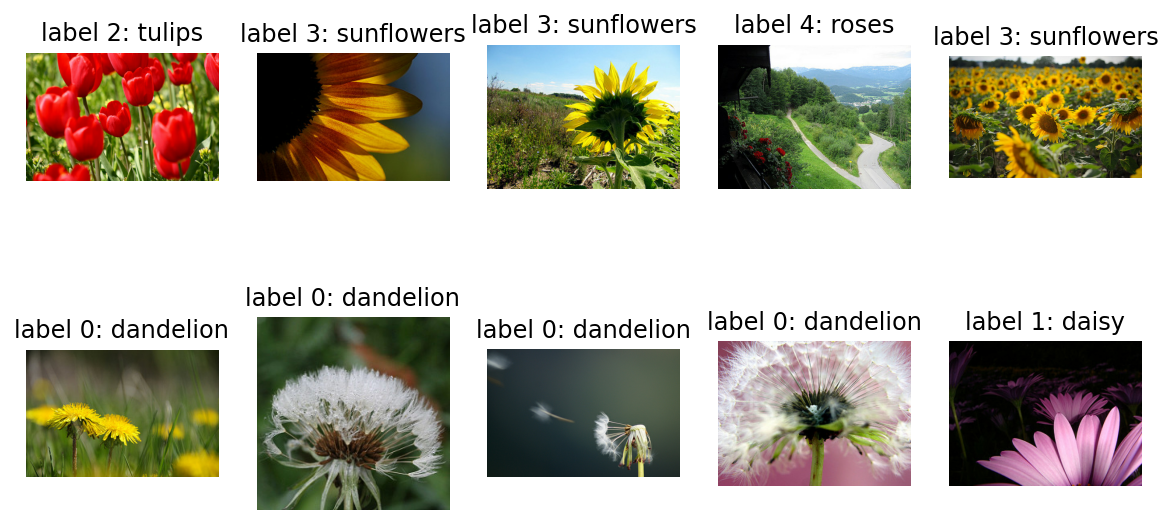

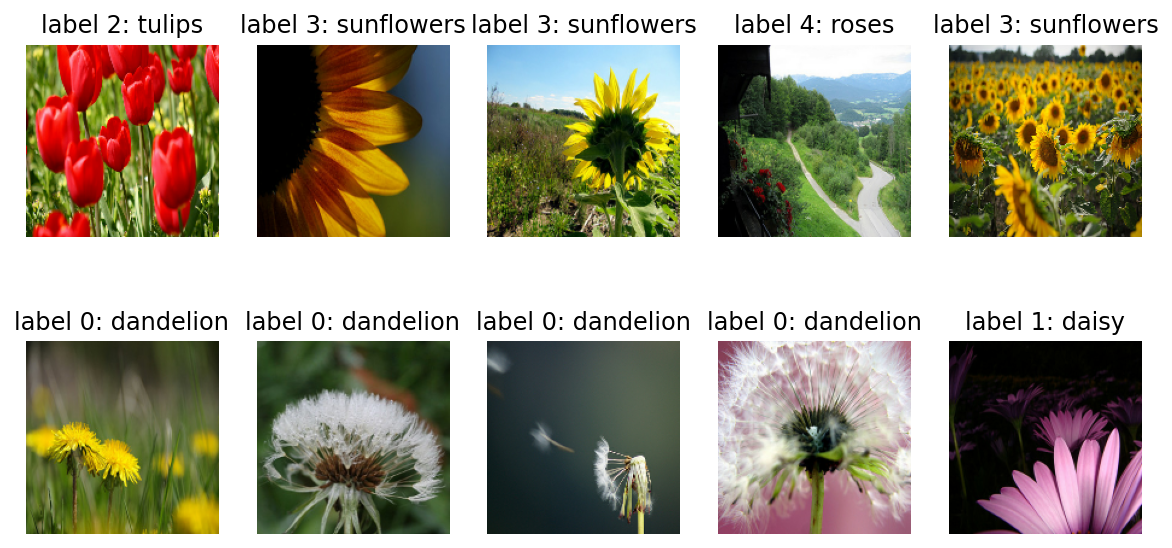

In [2]:

import matplotlib.pyplot as plt
import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


# Step 3. 모델 설계하기
모델은 어떤 방식으로 설계하고 싶은가요? 나만의 모델을 만들 것인가요, 아니면 base_model을 활용할 것인가요?
원하는 방식으로 모델을 만들어 보세요!
cats_vs_dogs 의 경우와 달리, tf_flowers 데이터셋에서는 class의 갯수가 5가지입니다. 모델 설계시 어느 부분이 달라질지에 유의해 주세요.

In [21]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
model_name = "VGG16"

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
# base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
model.summary()

base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# 체크포인트              
checkpoint_path = "weights/"+model_name+"/"+model_name+"-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

#텐서보드 로그 생성
log_dir = "logs/my_board/" + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


# Step 4. 모델 학습시키기
모델을 학습시켜봅니다. 단, 여기에서는 여러 가지 옵션을 바꿔볼 수 있습니다.
예를 들어, 모델 학습을 10 epoch보다 더 많이 시켜보거나, learning_rate 값을 바꿔볼 수 있습니다.
또는, optimizer의 종류도 바꿔볼 수 있습니다. 바꿔보고 싶다면, 여기를 참고하세요.
어쩌면 VGG16이 아닌 다른 모델을 base model로 활용할 수도 있을 것입니다. 그리고 파인튜닝을 fc layer의 구성에 변화를 줄 수 있을지도 모릅니다.
이전 스텝에서는 시도하지 않았던 Regularization 기법이 적용된다면 어떨까요? Dropout이나 Batch Normalization을 적용하는 것은 그리 어려운 일이 아닙니다.

In [22]:
EPOCHS = 20
history = model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches,callbacks=[cp_callback,tensorboard_callback])

Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: 1.6090 - accuracy: 0.2279
Epoch 00001: saving model to weights/VGG16/VGG16-0001.ckpt
92/92 [==============================] - 83s 908ms/step - loss: 1.6090 - accuracy: 0.2279 - val_loss: 1.5627 - val_accuracy: 0.3297
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: 1.5393 - accuracy: 0.3692
Epoch 00002: saving model to weights/VGG16/VGG16-0002.ckpt
92/92 [==============================] - 85s 922ms/step - loss: 1.5393 - accuracy: 0.3692 - val_loss: 1.5053 - val_accuracy: 0.4523
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: 1.4867 - accuracy: 0.4281
Epoch 00003: saving model to weights/VGG16/VGG16-0003.ckpt
92/92 [==============================] - 84s 917ms/step - loss: 1.4867 - accuracy: 0.4281 - val_loss: 1.4517 - val_accuracy: 0.4986
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss: 1.4376 - accuracy: 0.4833
Epoch 00004: saving model to weights/VGG16/VGG16-00

KeyboardInterrupt: 

# Step 5. 모델 성능 평가하기
모델 학습이 완료되었다면, 모델의 성능을 평가할 차례입니다.
모델이 학습된 과정을 그래프로도 그려보고, validation_batches나 test_batches에 있는 데이터에 대한 예측 결과도 확인해 보세요!

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:

for image_batch, label_batch in test_batches.take(2):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)

In [ ]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

In [ ]:
loss_and_metrics = model.evaluate(test_batches)

# Step 6. 모델 활용하기
모델이 꽤나 똑똑해졌다면, 이제 활용해볼 수 있습니다.
원하는 이미지를 자유롭게 모델에 입력해 보고, 어떤 예측 결과를 내는지 확인해 보세요!

In [9]:
model_name = "VGG19"
# Create the base model from the pre-trained model VGG19
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
# base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
model.summary()

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# 체크포인트              
checkpoint_path = "weights/"+model_name+"-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

#텐서보드 로그 생성
log_dir = "logs/my_board/" + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
EPOCHS = 20
history = model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches,callbacks=[cp_callback,tensorboard_callback])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: 1.4205 - accuracy: 0.4782
Epoch 00001: saving model to weights/VGG19-0001.ckpt
92/92 [==============================] - 85s 928ms/step - loss: 1.4205 - accuracy: 0.47

In [10]:
model_name = "efficientB0"
# Create the base model from the pre-trained model efficientB0
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
# base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
model.summary()

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# 체크포인트              
checkpoint_path = "weights/"+model_name+"-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

#텐서보드 로그 생성
log_dir = "logs/my_board/" + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
EPOCHS = 20
history = model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches,callbacks=[cp_callback,tensorboard_callback])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 5, 5, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 4,708,008
Trainable params: 658,437
Non-trainable params: 4,049,571
_________________________________________________________________
Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: 1.6077 - accuracy: 0.2456
Epoch 00001: saving model to weights/efficientB0-0001.ckpt
92/92 [==============================] - 22s 241ms/step - loss: 1.6077 - accuracy: 

In [18]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
model_name = "VGG16+RMS"

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
# base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
model.summary()

base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# 체크포인트              
checkpoint_path = "weights/"+model_name+"-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

#텐서보드 로그 생성
log_dir = "logs/my_board/" + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
EPOCHS = 20
history = model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches,callbacks=[cp_callback,tensorboard_callback])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: 1.6284 - accuracy: 0.2469
Epoch 00001: saving model to weights/VGG16+RMS-0001.ckpt
92/92 [==============================] - 80s 875ms/step - loss: 1.6284 - accuracy: 

KeyboardInterrupt: 

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
model_name = "VGG16+Adam+epoch30+lre-5"

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
# base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
model.summary()

base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# 체크포인트              
checkpoint_path = "weights/"+model_name+"-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

#텐서보드 로그 생성
log_dir = "logs/my_board/" + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
EPOCHS = 20
history = model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches,callbacks=[cp_callback,tensorboard_callback])


In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
model_name = "VGG16+method_test"

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
# base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
model.summary()

base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# 체크포인트              
checkpoint_path = "weights/"+model_name+"-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

#텐서보드 로그 생성
log_dir = "logs/my_board/" + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
EPOCHS = 20
history = model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches,callbacks=[cp_callback,tensorboard_callback])
